## 如何编写一个自定义的inspector
* 这里是一个稍复杂的示范过程: 检测指定的句子成分里是否包含指定的领域实体(crf训练识别), 比如obl成分中是否包含cuisine实体

* preqs: sagas/0.2.0, saai/0.2.4

In [1]:
from saai.multi_nlu_client import nlu_parse
from pprint import pprint
url='http://localhost:15008'
result=await nlu_parse(url, 'how about french food')
pprint(result)

{'entities': [{'confidence': 0.9960352006,
               'end': 16,
               'entity': 'cuisine',
               'extractor': 'CRFEntityExtractor',
               'start': 10,
               'value': 'french'}],
 'intent': {'confidence': 0.9999802113, 'name': 'inform'},
 'intent_ranking': [{'confidence': 0.9999802113, 'name': 'inform'},
                    {'confidence': 6.9449e-06, 'name': 'email_id'},
                    {'confidence': 5.7164e-06, 'name': 'mood_unhappy'},
                    {'confidence': 3.6971e-06, 'name': 'goodbye'},
                    {'confidence': 1.2413e-06, 'name': 'bot_challenge'},
                    {'confidence': 7.163e-07, 'name': 'greet'},
                    {'confidence': 5.65e-07, 'name': 'mood_great'},
                    {'confidence': 3.832e-07, 'name': 'order_now'},
                    {'confidence': 2.54e-07, 'name': 'request_info'},
                    {'confidence': 2.487e-07, 'name': 'thankyou'}],
 'text': 'how about french food'}


In [2]:
result['entities']

[{'start': 10,
  'end': 16,
  'value': 'french',
  'entity': 'cuisine',
  'confidence': 0.9960352006,
  'extractor': 'CRFEntityExtractor'}]

* 调用nlu-parse-api, 获取实体列表

In [16]:
from saai.tool import rasa_nlu_parse, rasa_nlu_vis
# sents='how about street food'
# sents='how about chinese food'
sents='how about north eastern food'

result=rasa_nlu_parse(sents, 'http://localhost:15008')
ents = result['entities']
ents

[{'start': 10,
  'end': 23,
  'value': 'north eastern',
  'entity': 'cuisine',
  'confidence': 0.7435030861,
  'extractor': 'CRFEntityExtractor'}]

* 实体可视化

In [4]:
rasa_nlu_vis(sents, 'http://localhost:15008')

BoxMarkup('how about north eastern food', [Span(10, 23, 'cuisine')])

* 句子的依存解析, 如果目标引擎包含了entity信息, 则显示非'O'的值

In [5]:
from sagas.nlu.ruleset_procs import list_words, cached_chunks, get_main_domains
from sagas.conf.conf import cf
lang='en'
chunks = cached_chunks(sents, lang, cf.engine(lang))
[(w.text, w.entity or 'O') for w in chunks['doc'].words]

[('how', 'O'),
 ('about', 'O'),
 ('north', 'O'),
 ('eastern', 'O'),
 ('food', 'O'),
 ('.', 'O')]

* 为所有的单词设置位置信息(start/end)

In [7]:
def set_word_positions(doc):
    running_offset = 0
    rs = []
    pos_map={}
    for token in doc.words:
        word = token.text    
        word_offset = sents.find(word, running_offset)
        if word_offset>-1:
            word_len = len(word)
            running_offset = word_offset + word_len
            pos_map[token.index]=(word_offset, running_offset)
    return pos_map

pos_map=set_word_positions(chunks['doc'])
print([(w.text, w.index) for w in chunks['doc'].words])
pos_map

[('how', '1'), ('about', '2'), ('north', '3'), ('eastern', '4'), ('food', '5'), ('.', '6')]


{'1': (0, 3), '2': (4, 9), '3': (10, 15), '4': (16, 23), '5': (24, 28)}

* 对照单词的位置和实体的位置, 进行匹配, 就可以得到单词属于哪个实体(一个实体往往包含多个单词)

In [8]:
def get_entity_mapping(doc):
    running_offset = 0
    rs = []
    for token in doc.words:
        word = token.text    
        word_offset = sents.find(word, running_offset)
        if word_offset>-1:
            word_len = len(word)
            running_offset = word_offset + word_len
            print(f"{word} - ({word_offset}, {running_offset})")
            for ent in ents:
                start, end=ent['start'], ent['end']
                if word_offset>=start and running_offset<=end:
                    rs.append({"start": word_offset,
                               "end": running_offset,
                               'index': token.index,
                               'value': word,
                               'entity': ent['entity']
                               })
    return rs

get_entity_mapping(chunks['doc'])

how - (0, 3)
about - (4, 9)
north - (10, 15)
eastern - (16, 23)
food - (24, 28)


[{'start': 10, 'end': 15, 'index': '3', 'value': 'north', 'entity': 'cuisine'},
 {'start': 16,
  'end': 23,
  'index': '4',
  'value': 'eastern',
  'entity': 'cuisine'}]

In [17]:
for ent in ents:
    word=ent['value']
    word_offset = sents.index(word, ent['start'])
    print(word_offset)

10


* 显示句子的依存解析图;
* 解析方式有多种, 按优先级分别是: predicate(谓词论元), verb, aux, subj, root

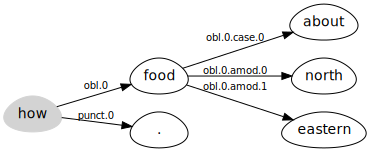

In [10]:
from sagas.kit.analysis_kit import vis_domains
for v in vis_domains(sents, 'en', all_subsents=True): display(v)

In [11]:
from sagas.tracker_jupyter import enable_jupyter_tracker
enable_jupyter_tracker()

* 显示句子的成分列表和概念引用, 帮助分析
* 每个单词都有index索引号, 因为单词在句子中有可能重复, 所以用这个索引号作为唯一标识

In [12]:
from sagas.nlu.uni_remote_viz import list_contrast, list_rs, display_doc_deps
from sagas.nlu.corenlp_parser import get_chunks

rs = get_chunks(chunks['doc'])
list_rs(rs, 'en')
_=list_contrast(rs, 'en')

✁ chunks. -------------------------
❶ root_domains(how) _


,rel,index,text,lemma,children,features
0,obl,5,food,food,"about, north, e..","c_noun, x_nn.."
1,punct,6,.,.,...,"c_punct, x_..."


obl -> about north eastern food
♥ food(obl): food.n.01, food.n.02, foo...
[root_domains](how) 怎么样
	[obl](about north eastern food) 关于东北粮食


* 查找index为5的单词 (根据上面的列表可以得知obl成分的主词food, 索引是5)

In [18]:
sent=chunks['doc']

word_idx='5'
word=next(filter(lambda w: w.index == word_idx, sent.words))
word.text

'food'

* 获取主词food的所有子结点(可参考前面的分析树)
* 根据子结点的索引, 得到所有子结点对应的实体

In [14]:
from sagas.nlu.corenlp_parser import get_children
def get_children_index(sent, word_idx):
    rs = []
    word=next(filter(lambda w: w.index == word_idx, sent.words))
    get_children(sent, word, rs, stem=False)
    return [word_idx]+[w[0] for w in rs]

sent=chunks['doc']
# obl index is '5'
indexes=get_children_index(sent, '5')
print(indexes)
idx_ent={el['index']:el['entity'] for el in get_entity_mapping(sent)}
# print(idx_ent)
children_ents=[(idx, idx_ent[idx] if idx in idx_ent else '_') for idx in indexes]
children_ents

['5', '2', '3', '4']
how - (0, 3)
about - (4, 9)
north - (10, 15)
eastern - (16, 23)
food - (24, 28)


[('5', '_'), ('2', '_'), ('3', 'cuisine'), ('4', 'cuisine')]

* 测试: 指定的句子成分(即food的所有子结点, 也包括food自身)是否包含指定的实体cuisine

In [15]:
print(idx_ent)

# test specific entity in the children
test_ent='cuisine'
test_ent in {e[1] for e in children_ents}

{'3': 'cuisine', '4': 'cuisine'}


True